In [1]:
# import packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import idx2numpy
import os
import pickle
from PIL import Image

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchsummary import summary
import copy

In [2]:
# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Define transformations to be applied to the CIFAR10 dataset
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Load the CIFAR10 dataset
trainset = datasets.CIFAR10(root='../datasets', train=True, download=True, transform=transform)
valset = datasets.CIFAR10(root='../datasets', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../datasets', train=False, download=True, transform=transform)

# Create a DataLoader for the CIFAR10 dataset
trainloader = DataLoader(trainset, batch_size=128, num_workers=2, 
                                          sampler=sampler.SubsetRandomSampler(range(45000)))

valloader = DataLoader(valset, batch_size=128, num_workers=2, 
                                          sampler=sampler.SubsetRandomSampler(range(45000, 50000)))

testloader = DataLoader(testset, batch_size=1000, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
X_train = trainset.data
y_train = trainset.targets

In [43]:
X_test = testset.data
y_test = testset.targets

### Data augmentation

In [5]:
# Define the rotation function
def img_rotate(img, deg=1):
    img1 = np.transpose(img, (1, 2, 0))
    img1 = np.rot90(img1, deg)
    return np.transpose(img1, (2, 0, 1))

In [6]:
# Expand X_train and y_train
X_train_all = []
y_train_all = []

for (x, y) in zip(X_train, y_train):
    X_train_all.append(x.reshape(1, 32, 32, 3))
    X_train_all.append(img_rotate(x).reshape(1, 32, 32, 3))
    X_train_all.append(img_rotate(x, 2).reshape(1, 32, 32, 3))
    X_train_all.append(img_rotate(x, 3).reshape(1, 32, 32, 3))

    for i in range(4):
        y_train_all.append((y, i))


In [7]:
X_train_all = torch.Tensor(np.vstack(X_train_all))
y_train_all = torch.Tensor(np.array(y_train_all, dtype=np.int64))

print(X_train_all.shape)

torch.Size([200000, 32, 32, 3])


In [8]:
#X_train_all = torch.Tensor(np.array(X_train_all, dtype=np.float32))
#y_train_all = torch.Tensor(np.array(y_train_all, dtype=np.int64))

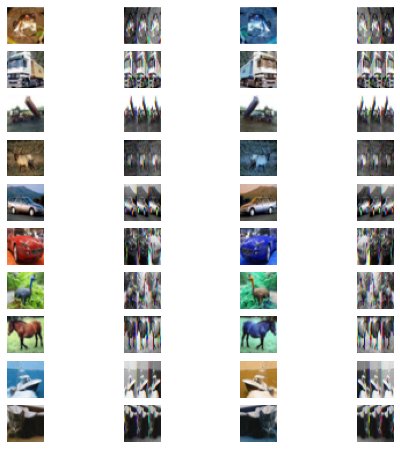

tensor([[6., 0.],
        [6., 1.],
        [6., 2.],
        [6., 3.],
        [9., 0.],
        [9., 1.],
        [9., 2.],
        [9., 3.],
        [9., 0.],
        [9., 1.],
        [9., 2.],
        [9., 3.],
        [4., 0.],
        [4., 1.],
        [4., 2.],
        [4., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [2., 0.],
        [2., 1.],
        [2., 2.],
        [2., 3.],
        [7., 0.],
        [7., 1.],
        [7., 2.],
        [7., 3.],
        [8., 0.],
        [8., 1.],
        [8., 2.],
        [8., 3.],
        [3., 0.],
        [3., 1.],
        [3., 2.],
        [3., 3.]])


In [9]:
# Display 40 images from X_train_all
fig, axs = plt.subplots(10, 4, figsize=(8, 8))
for i in range(10):
    for j in range(4):
        axs[i, j].imshow(X_train_all[i*4+j]/255.0)
        axs[i, j].axis("off")
plt.show()
print(y_train_all[:40])

In [10]:
#new_images = []

#for i in X_train:
#    new_images.extend(data_augmentation(i, 1))

#X_train_new = np.concatenate([X_train, np.array(new_images)], axis=0)
#y_train_new = np.concatenate([y_train, y_train], axis=0)

#print(X_train_new.shape)
#print(y_train_new.shape)

### Training

In [34]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, num_block=1):
        super(ResBlock, self).__init__()
        self.num_block = num_block
        self.layers = nn.ModuleList([])
        
        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride)
        ))
        self.layers.append(nn.Sequential  (
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=stride),
#             nn.GroupNorm(out_channel//4, out_channel),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
            nn.GroupNorm(out_channel//4, out_channel),
            nn.ReLU(inplace=True)
        ))
        
        for _ in range(1, num_block):
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=1, stride=1)
            ))
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            ))
    
    def forward(self, x):
        for i in range(self.num_block):
            x_identity = self.layers[2*i](x)
            x = self.layers[2*i+1](x)
            x = F.relu(x + x_identity, inplace=True) 
        
        return x
    

class JointResNet(nn.Module):
    def __init__(self):
        super(JointResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
#         self.gn1 = nn.GroupNorm(4, 16)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layers1 = ResBlock(16, 16, num_block=4)
        self.layers2 = ResBlock(16, 32, stride=2, num_block=4)
        self.layers3_1 = ResBlock(32, 64, stride=2, num_block=4)
        self.layers3_2 = ResBlock(32, 64, stride=2, num_block=4)
        
        self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 10)
        
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(64, 4)
        
        
    def forward(self, x):
        x = self.conv1(x)
#         x = self.gn1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.layers1(x)
        x = self.layers2(x)
        
        x1 = self.layers3_1(x)
        x1 = self.avgpool1(x1)
        x1 = x1.view(-1, 64)
        x1 = self.fc1(x1)
        
        x2 = self.layers3_2(x)
        x2 = self.avgpool2(x2)
        x2 = x2.view(-1, 64)
        x2 = self.fc2(x2)
        return x1, x2  
    

# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Image classification test

In [13]:
# Define the loss functions
criterion = nn.CrossEntropyLoss()

# Initialize the model and define optimizer
model = JointResNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [14]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             272
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,320
         GroupNorm-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]             272
           Conv2d-11           [-1, 16, 32, 32]           2,320
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [15]:
# Train the model
num_epochs = 00
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        labels = labels.long()
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        out = model(images)

        # Compute the loss
        loss = criterion(out, labels)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')
            check_accuracy(valloader, model)

Epoch [1/500], Step [100/352], Loss: 1.7604
Got 913 / 5000 correct (18.26)
Epoch [1/500], Step [200/352], Loss: 2.0957
Got 997 / 5000 correct (19.94)
Epoch [1/500], Step [300/352], Loss: 2.0483
Got 1243 / 5000 correct (24.86)
Epoch [2/500], Step [100/352], Loss: 1.8094
Got 1384 / 5000 correct (27.68)
Epoch [2/500], Step [200/352], Loss: 1.7736
Got 1477 / 5000 correct (29.54)
Epoch [2/500], Step [300/352], Loss: 1.9125
Got 1512 / 5000 correct (30.24)
Epoch [3/500], Step [100/352], Loss: 1.6971
Got 1630 / 5000 correct (32.60)
Epoch [3/500], Step [200/352], Loss: 1.8653
Got 1586 / 5000 correct (31.72)
Epoch [3/500], Step [300/352], Loss: 1.8525
Got 1767 / 5000 correct (35.34)
Epoch [4/500], Step [100/352], Loss: 1.5767
Got 1765 / 5000 correct (35.30)
Epoch [4/500], Step [200/352], Loss: 1.6037
Got 1948 / 5000 correct (38.96)
Epoch [4/500], Step [300/352], Loss: 1.7162
Got 2013 / 5000 correct (40.26)
Epoch [5/500], Step [100/352], Loss: 1.5995
Got 2092 / 5000 correct (41.84)
Epoch [5/500],

In [16]:
# Compute the accuracy on the test set
correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        labels = labels.to(torch.int64)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        out = model(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct / total))

Accuracy for image classification: 85.45 %


### Joint Train

In [58]:
# Set up the data loaders
train_loader = DataLoader(MyDataset(X_train_all.permute(0, 3, 1, 2), y_train_all), batch_size=1000, shuffle=False)

# Define the loss functions
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()


# Initialize the model and define optimizer
model1 = JointResNet().to(device)
optimizer1 = optim.AdamW(model1.parameters(), lr=0.001, weight_decay=0.0001)

In [59]:
summary(model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             272
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,320
         GroupNorm-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]             272
           Conv2d-11           [-1, 16, 32, 32]           2,320
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [60]:
# Train the model
num_epochs = 25
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)
        
        # Zero the gradients
        optimizer1.zero_grad()

        # Forward pass
        out1, out2 = model1(images)

        # Compute the loss
        loss1 = criterion1(out1, labels_1)
        loss2 = criterion2(out2, labels_2)
        loss = loss1 + loss2

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer1.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/75], Step [100/200], Loss: 2.0699
Epoch [1/75], Step [200/200], Loss: 1.7616
Epoch [2/75], Step [100/200], Loss: 1.5880
Epoch [2/75], Step [200/200], Loss: 1.4325
Epoch [3/75], Step [100/200], Loss: 1.3140
Epoch [3/75], Step [200/200], Loss: 1.2347
Epoch [4/75], Step [100/200], Loss: 1.1565
Epoch [4/75], Step [200/200], Loss: 1.1031
Epoch [5/75], Step [100/200], Loss: 1.0548
Epoch [5/75], Step [200/200], Loss: 0.9851
Epoch [6/75], Step [100/200], Loss: 1.0127
Epoch [6/75], Step [200/200], Loss: 0.8989
Epoch [7/75], Step [100/200], Loss: 0.9571
Epoch [7/75], Step [200/200], Loss: 0.8078
Epoch [8/75], Step [100/200], Loss: 0.8969
Epoch [8/75], Step [200/200], Loss: 0.7681
Epoch [9/75], Step [100/200], Loss: 0.8619
Epoch [9/75], Step [200/200], Loss: 0.7056
Epoch [10/75], Step [100/200], Loss: 0.8113
Epoch [10/75], Step [200/200], Loss: 0.6652
Epoch [11/75], Step [100/200], Loss: 0.7695
Epoch [11/75], Step [200/200], Loss: 0.6452
Epoch [12/75], Step [100/200], Loss: 0.7551
Epoch 

KeyboardInterrupt: 

In [61]:
# Expand X_test and y_test
X_test_all = []
y_test_all = []

for (x, y) in zip(X_test, y_test):
    X_test_all.append(x.reshape(1, 32, 32, 3))
    X_test_all.append(img_rotate(x).reshape(1, 32, 32, 3))
    X_test_all.append(img_rotate(x, 2).reshape(1, 32, 32, 3))
    X_test_all.append(img_rotate(x, 3).reshape(1, 32, 32, 3))

    for i in range(4):
        y_test_all.append((y, i))

        
X_test_all = torch.Tensor(np.vstack(X_test_all))
y_test_all = torch.Tensor(np.array(y_test_all, dtype=np.int64))

In [62]:
test_loader = DataLoader(MyDataset(X_test_all.permute(0, 3, 1, 2), y_test_all), batch_size=1000, shuffle=False)

# Compute the accuracy on the test set
correct1 = 0
correct2 = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)

        # Forward pass
        out1, out2 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct1 += (predicted == labels_1).sum().item()
        _, predicted = torch.max(out2.data, 1)
        correct2 += (predicted == labels_2).sum().item()
        total += labels_2.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct1 / total))
print('Accuracy for rotation classification: {:.2f} %'.format(100 * correct2 / total))

Accuracy for image classification: 75.38 %
Accuracy for rotation classification: 85.59 %


In [65]:
torch.save(model1.state_dict(), 'model1.pth')

### Test-Time Training